# Import Libraries

In [43]:
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GroupShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Load the data

In [44]:
df = pd.read_csv("../data/processed/youtube_combined_data.csv")
print(f"Data loaded with shape: {df.shape}")

%run "./02_data_cleaning.ipynb"
%run "./03_feature_engineering.ipynb"

df = clean_data(df)
df = feature_engineering(df)
df = drop_unused_columns(df)

print(f"Data after preprocessing has shape: {df.shape}")


Data loaded with shape: (50160, 16)
Data after preprocessing has shape: (49229, 17)


In [45]:
# Define target and feature lists

target = "engagement_rate_log"

categorical_features = ['category_id', 'captions_flag']

numeric_features = [
    'total_videos','channel_age_days','title_length','title_words',
    'title_exclamation','title_question',
    'duration_minutes','publish_hour_sin','publish_hour_cos',
    'publish_dow_sin','publish_dow_cos',
    'subscriber_count_log','is_hd'
]

all_features = categorical_features + numeric_features


# GROUP SPLIT

In [46]:
X = df[all_features].copy()
y = df[target].copy()
groups = df['channel_id']

gss = GroupShuffleSplit(
    test_size=0.2,
    n_splits=1,
    random_state=42
)

train_idx, test_idx = next(gss.split(X, y, groups))

X_train = X.iloc[train_idx].copy()
X_test  = X.iloc[test_idx].copy()
y_train = y.iloc[train_idx].copy()
y_test  = y.iloc[test_idx].copy()


In [47]:
train_means = y_train.groupby(X_train['category_id']).mean()

X_train['category_te'] = X_train['category_id'].map(train_means)
X_test['category_te']  = X_test['category_id'].map(train_means)

numeric_features.append('category_te')


In [48]:
# Clipping of numeric features

def robust_clip(train_col, test_col):
    q1, q3 = train_col.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return train_col.clip(lo, hi), test_col.clip(lo, hi)


for col in ['total_videos', 'channel_age_days']:
    X_train[col], X_test[col] = robust_clip(X_train[col], X_test[col])


In [49]:
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col]  = X_test[col].astype('category')


# Model Fit

In [50]:
base_model = LGBMRegressor(
    objective='regression',
    metric='mae',
    bagging_fraction=0.85,
    bagging_freq=5,
    lambda_l1=5,
    lambda_l2=10,
    verbosity=-1,
    random_state=42
)

In [51]:
param_grid = {
    "learning_rate": [0.03, 0.05],
    "num_leaves": [15, 31],
    "max_depth": [4, 5],
    "min_child_samples": [50, 100],
    "feature_fraction": [0.7, 0.8]
}

search = HalvingGridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    factor=2,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1
)

search.fit(
    X_train,
    y_train,
    categorical_feature=categorical_features
)

print("BEST PARAMS:", search.best_params_)


n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 1233
max_resources_: 39475
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 32
n_resources: 1233
Fitting 3 folds for each of 32 candidates, totalling 96 fits
----------
iter: 1
n_candidates: 16
n_resources: 2466
Fitting 3 folds for each of 16 candidates, totalling 48 fits
----------
iter: 2
n_candidates: 8
n_resources: 4932
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 4
n_resources: 9864
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 4
n_candidates: 2
n_resources: 19728
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 5
n_candidates: 1
n_resources: 39456
Fitting 3 folds for each of 1 candidates, totalling 3 fits
BEST PARAMS: {'feature_fraction': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 50, 'num_leaves': 31}


In [52]:
final_model = LGBMRegressor(
    **search.best_params_,
    objective='regression',
    metric='mae',
    random_state=42
)

final_model.fit(
    X_train,
    y_train,
    categorical_feature=categorical_features
)


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.05
,n_estimators,100
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,50


In [53]:
y_pred = np.clip(
    final_model.predict(X_test),
    y_train.min(),
    y_train.max()
)

y_train_pred = np.clip(
    final_model.predict(X_train),
    y_train.min(),
    y_train.max()
)


# Evaluation

In [54]:
print("====== TEST PERFORMANCE ======")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

print("\n====== TRAIN PERFORMANCE ======")
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Train R2:", r2_score(y_train, y_train_pred))


====== TEST PERFORMANCE ======
MAE: 0.15332148640893015
RMSE: 0.2098752588709308
R2: 0.2716315575670606

====== TRAIN PERFORMANCE ======
MAE: 0.13882573832730966
Train RMSE: 0.1908179002093625
Train R2: 0.38405677570481644


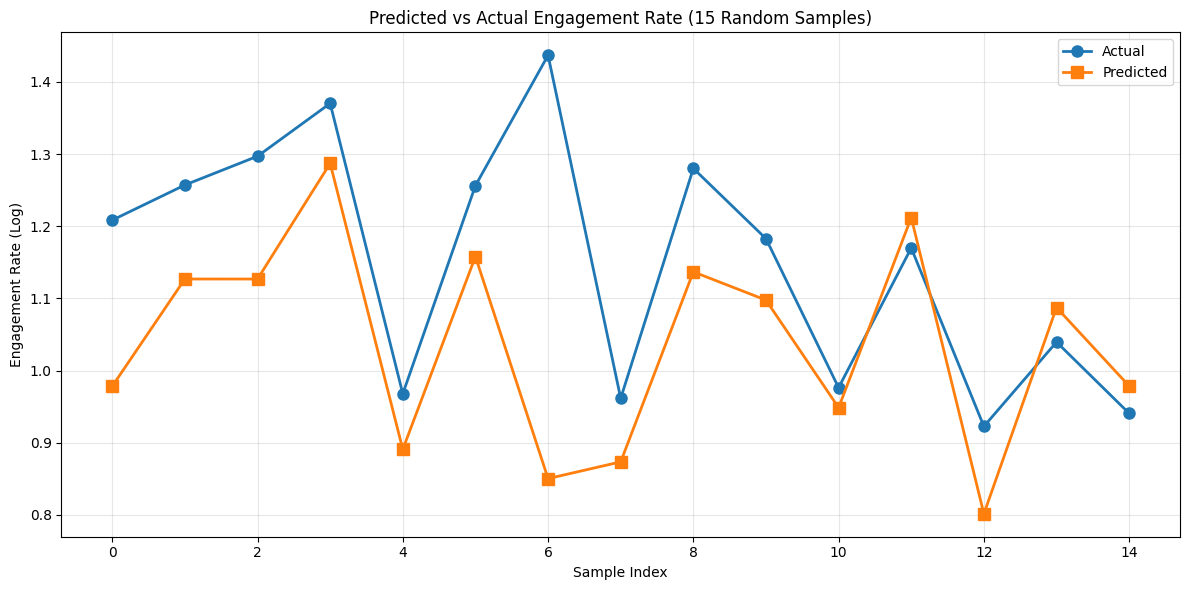

In [60]:
import matplotlib.pyplot as plt

# Select random 15 indices from test set
random_indices = np.random.choice(len(y_test), 15, replace=False)
random_indices = sorted(random_indices)

# Get actual and predicted values
actual_values = y_test.iloc[random_indices].values
predicted_values = y_pred[random_indices]

# Create line chart
plt.figure(figsize=(12, 6))
plt.plot(range(15), actual_values, marker='o', label='Actual', linewidth=2, markersize=8)
plt.plot(range(15), predicted_values, marker='s', label='Predicted', linewidth=2, markersize=8)
plt.xlabel('Sample Index')
plt.ylabel('Engagement Rate (Log)')
plt.title('Predicted vs Actual Engagement Rate (15 Random Samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()